### Instalamos dependencias

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Leemos el CSV que habíamos preparado anteriormente y estandarizamos el tiempo

In [4]:
df=pd.read_csv("05-transacciones_tarjeta.csv")

In [7]:
df["time"] = pd.to_datetime(df["time"])

### Creamos la columna "possible_fraud" para poder filtrar las transacciones con facilidad

In [52]:
df['possible_fraud'] = "N"

### Definimos lastransacciones hechas a altas horas de la noche 
(por ejemplo, de 02:00 a 05:00)

In [85]:
df['hour'] = df['time'].dt.hour
df['possible_fraud'] = np.where((df['hour'] >= 2) & (df['hour'] <= 5), 'Y', 'N')

### Calculamos el umbral para grandes cantidades (por ejemplo, transacciones mayores al percentil 99)

In [86]:
threshold = df['amount(eur)'].quantile(0.99)
df['possible_fraud'] = np.where(df['amount(eur)'] > threshold, 'Y', df['possible_fraud'])

### Calculamos la media y desviación estándar de las transacciones de cada usuario

In [87]:
user_stats = df.groupby('client_id')['amount(eur)'].agg(mean_amount=('mean'), std_amount=('std')).reset_index()
df = df.merge(user_stats, on='client_id', how='left', suffixes=('', '_user'))

### Procedemos a identificar transacciones que se desvían significativamente de la media del usuario 
(por ejemplo, más de 3 desviaciones estándar)

In [ ]:
df['z_score'] = (df['amount(eur)'] - df['mean_amount']) / df['std_amount']
df['possible_fraud'] = np.where(np.abs(df['z_score']) > 5, 'Y', df['possible_fraud'])

### Ahora, contaremos las posibles transacciones fraudulentas

In [89]:
fraud_count = df[df['possible_fraud'] == 'Y'].shape[0]
total_transactions = df.shape[0]
fraud_percentage = (fraud_count / total_transactions) * 100

print(f"El porcentaje de transacciones marcadas como posible fraude es: {fraud_percentage:.2f}%")

El porcentaje de transacciones marcadas como posible fraude es: 17.26%


### Hacemos una visualización para observar la cantidad

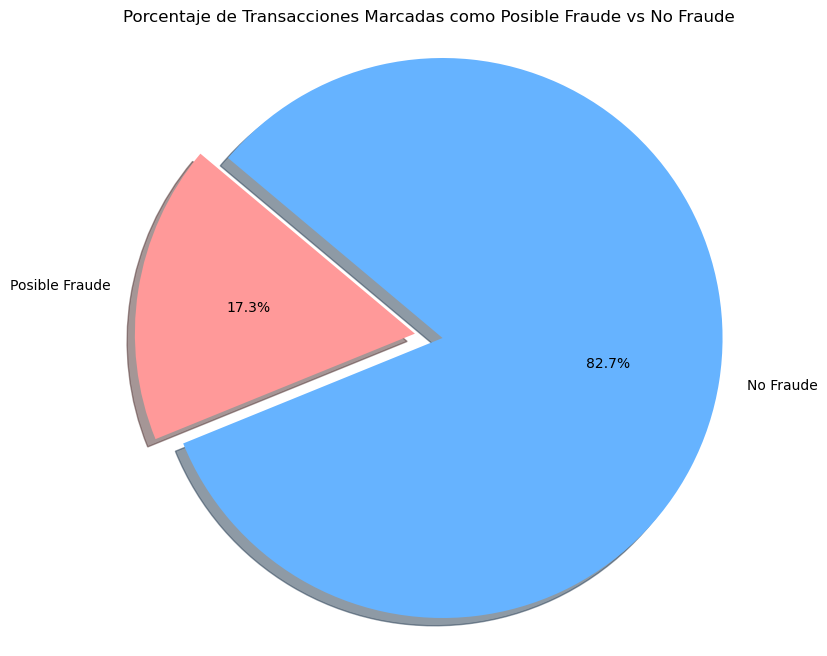

In [90]:
# Contar el número de transacciones marcadas como posible fraude y no fraude
fraud_count = df[df['possible_fraud'] == 'Y'].shape[0]
non_fraud_count = df[df['possible_fraud'] == 'N'].shape[0]

# Datos para el gráfico circular
labels = ['Posible Fraude', 'No Fraude']
sizes = [fraud_count, non_fraud_count]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # Extruir el  (Posible Fraude)

# Crear el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Porcentaje de Transacciones Marcadas como Posible Fraude vs No Fraude')
plt.axis('equal')  # Asegurar que el gráfico de pastel es un círculo
plt.show()
